<a href="https://colab.research.google.com/github/dddonghwa/IAB/blob/main/3_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [OpenCV-Python Tutorial] Classification

In this notebook, we will learn how to perform Object Classification using Visual Bag of Words(VBoW), spatial histogram feature, and SVM classifier.

---

In [2]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 102 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6 MB 26 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
import os, sys
import tarfile
import time
import random
import pickle
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# download dataset
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp" -O 101_ObjectCategories.tar.gz && rm -rf /tmp/cookies.txt


--2021-09-22 04:36:01--  https://docs.google.com/uc?export=download&confirm=O1Gc&id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
Resolving docs.google.com (docs.google.com)... 173.194.218.113, 173.194.218.101, 173.194.218.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.218.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-as-docs.googleusercontent.com/docs/securesc/3ubk17q94un50hg43v4n3hcfh1b5vpb8/b8o1erepldmph6g303ihgoi6ce4vmqio/1632285300000/15424859768005087218/02850946561110370940Z/137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp?e=download [following]
--2021-09-22 04:36:02--  https://doc-0s-as-docs.googleusercontent.com/docs/securesc/3ubk17q94un50hg43v4n3hcfh1b5vpb8/b8o1erepldmph6g303ihgoi6ce4vmqio/1632285300000/15424859768005087218/02850946561110370940Z/137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp?e=download
Resolving doc-0s-as-docs.googleusercontent.com (doc-0s-as-docs.googleusercontent.com)... 173.194.215.132, 2607:f8b0:400c:c0c::84
Conne

In [5]:
caltech_url = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'
caltech_filename = '101_ObjectCategories.tar.gz'
caltech_dir = '101_ObjectCategories/'

numTrain = 15
numTest = 15
numClasses = 102
numWords = 600

vocabPath = 'vocab.pkl'
svmPath = os.path.join(caltech_dir, 'svm_data.dat')

# Dataset

## 1. Download Caltech-101 dataset

In [6]:
if not os.path.exists(caltech_dir) or not os.path.exists(os.path.join(caltech_dir, 'airplanes')):
    print('Extracting Caltech-101')
    with tarfile.open(caltech_filename) as tar:
        tar.extractall()

print('Caltech-101 dataset checked')

Extracting Caltech-101
Caltech-101 dataset checked


## 2. Setup Data

# Dense SIFT(PHOW) and Visual Words

Select 15 train/test images for each class
done


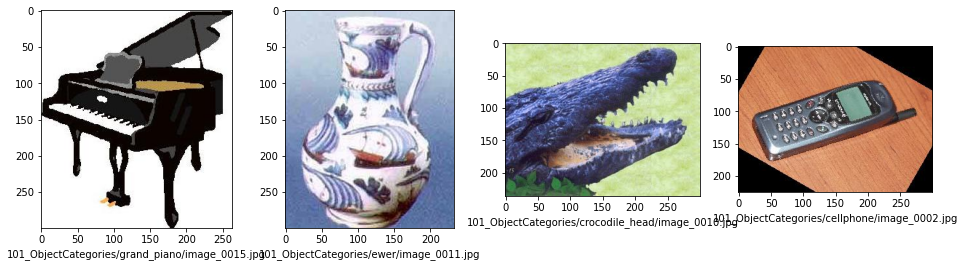

In [7]:
# Select 15 train/test images for each class
print('Select 15 train/test images for each class')
classes = next(os.walk(caltech_dir))[1]
train_image_ll = []
test_image_ll = []
for c in classes:
    class_dir = os.path.join(caltech_dir, c, '*.jpg')
    ims = glob(class_dir)
    ims.sort()
    train_image_ll.append([f for f in ims[:numTrain]])
    test_image_ll.append([f for f in ims[numTrain:numTrain+numTest]])
print('done')

# Show 4 random images
plt.figure(figsize=(16,4))
for i, idx in enumerate(random.sample(range(len(classes)), 4)):
    fpath = random.sample(train_image_ll[idx], 1)[0]
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel(fpath)

## 1. SIFT helper functions

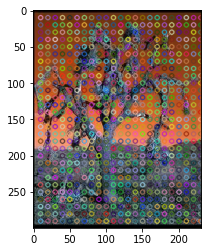

In [8]:
sift = cv2.xfeatures2d.SIFT_create()

# Resize a image if it's too large
def standarizeImage(img):
    rows, cols = img.shape
    if cols > 480:
        img = cv2.resize(img, (480, int(rows*480/cols)))
    return img

# Detect and extract SIFT from a single image
def SIFT(img):
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

# Load an image + Resize if large + Extract SIFT
def SIFT2(img_fpath):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return SIFT(img)

# Dense SIFT(Extract SIFT descriptor in grid points over an image)
def denseSIFT(img, step = 10, size = 7):
    rows, cols = img.shape[:2]
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    return kp, des

# Load an image + Resize if large + Dense SIFT
def denseSIFT2(img_fpath, step = 10):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return denseSIFT(img, step)

# Dense SIFT
tmp_im = cv2.cvtColor(cv2.imread(train_image_ll[0][0]), cv2.COLOR_BGR2RGB)
#kp, des = SIFT(tmp_im)
kp, des = denseSIFT(tmp_im)
im_sift = cv2.drawKeypoints(tmp_im, kp, None)
plt.imshow(cv2.cvtColor(im_sift, cv2.COLOR_BGR2RGB))

## 2. Visual Words(Train Vocabulary)

In [9]:
# Download pre-extracted vocab.pkl
!wget https://raw.githubusercontent.com/bckim92/iab_practice_example/master/vocab.pkl

--2021-09-22 04:37:39--  https://raw.githubusercontent.com/bckim92/iab_practice_example/master/vocab.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307361 (300K) [application/octet-stream]
Saving to: ‘vocab.pkl’

vocab.pkl           100%[===================>] 300.16K  --.-KB/s    in 0.03s   

2021-09-22 04:37:39 (8.89 MB/s) - ‘vocab.pkl’ saved [307361/307361]



In [15]:
# Train vocabulary
if not os.path.exists(vocabPath):
    # Get PHOW features from 30 random training image to build a dictionary
    print("Extracting PHOW features some training images...")
    PHOW_descrs = []
    temp = [item for sublist in train_image_ll for item in sublist]
    temp = random.sample(temp, 30)
    for fpath in temp:
        _, des = denseSIFT2(fpath)
        PHOW_descrs.append(des)
    PHOW_descrs = np.concatenate(PHOW_descrs, axis=0)
    print("Total {} PHOW features".format(PHOW_descrs.shape[0]))
    
    # Quantize the descriptors to get the visual words
    print("Running K-means clustering ({} -> {})...".format(PHOW_descrs.shape[0], numWords))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 1.0)
    attempts = 10
    flags = cv2.KMEANS_RANDOM_CENTERS
    start_time = time.time()
    retval, bestLabels, vocab = cv2.kmeans(PHOW_descrs, numWords, None, criteria, attempts, flags)
    print('Elapsed time: {:6}s'.format(time.time() - start_time))
    
    print('Saving...') 
    with open(vocabPath, 'wb') as fd:
        pickle.dump(vocab, fd)
else:
    print("Load the trained visual words...")
    with open(vocabPath, 'rb') as fd:
        vocab = pickle.load(fd)

print('Done!')

Extracting PHOW features some training images...
Total 19600 PHOW features
Running K-means clustering (19600 -> 600)...
Elapsed time: 815.6566042900085s
Saving...
Done!


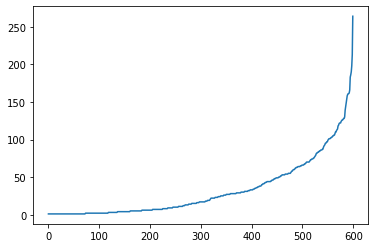

In [16]:
import collections
myCounter = collections.Counter(bestLabels.flatten())
plt.plot(sorted(myCounter.values()))

# Classification - SVM

## Spatial Histogram

In [32]:
bf = cv2.BFMatcher()

def getImageDescriptor(img, step=10, size=7):
    img = standarizeImage(img)
    cols, rows = img.shape[:2]
    
    # Extracting denseSIFT and BoW
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    matches = bf.knnMatch(des, vocab, k=1)
    words = [m[0].trainIdx for m in matches] 
    
    # Spatial Binning - 2x2
    binX = 2; binY = 2;
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
        i = int((k.pt[0]) * binX / cols)
        j = int((k.pt[1]) * binY / rows)
        temp[i, j, w] += 1
    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] /= np.sum(temp[i, j, :]) # 각 histogram의 normalization
    temp = temp.flatten()
    hist = temp
    
    # Spatial Binning - 4x4
    ################################
    # TODO : your code here
    temp = []

    binX = 4; binY = 4;
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
      i = int((k.pt[0]) * binX / cols) 
      j = int((k.pt[1]) * binY/ rows)
      temp[i, j, w] += 1
    for i in range(binX) :
      for j in range(binY):
        temp[i, j, :] /= np.sum(temp[i, j, :]) 
    temp = temp.flatten()

    ################################
    hist = np.concatenate((hist, temp), axis=0)
    hist /= np.sum(hist)
    print(hist.shape)
    return hist    

## 1. Genarate spatial histogram for Training Images

In [98]:
# Extract spartial histogram for all training images
print('Extract spartial histogram for all training images')
BoW_train_ll = []
for c, image_list in zip(classes, train_image_ll):
    print(c, end=' '), 
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_train_ll.append(temp)

print('\ndone!')

Extract spartial histogram for all training images
joshua_tree brain hedgehog BACKGROUND_Google mandolin flamingo_head Leopards soccer_ball Faces_easy pagoda euphonium crocodile_head hawksbill pyramid barrel dollar_bill stop_sign nautilus yin_yang cougar_body grand_piano chandelier bass scorpion cougar_face elephant chair sea_horse pizza crab ibis electric_guitar inline_skate scissors rhino pigeon lobster flamingo schooner ferry saxophone crayfish stegosaurus headphone dalmatian llama lotus wrench anchor water_lilly cup helicopter airplanes ewer revolver okapi kangaroo watch Motorbikes ceiling_fan minaret binocular tick mayfly trilobite panda bonsai butterfly Faces accordion buddha crocodile wheelchair lamp sunflower menorah beaver windsor_chair stapler starfish platypus dragonfly car_side cellphone dolphin snoopy camera wild_cat emu garfield laptop strawberry ketch ant brontosaurus umbrella metronome rooster octopus gerenuk gramophone cannon 
done!


## 2. Train SVM

In [102]:
# Setting training data(BoW, label) for SVM
print('Setting training data(BoW, label) for SVM')
train_bow = []
train_labels = []
numSpartialHist = len(BoW_train_ll[0][0])
for i, BoW_list in enumerate(BoW_train_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow)
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        train_bow.append([temp])
    train_labels.extend([i] * len(BoW_list))
train_bow = np.concatenate(train_bow, axis=0).astype(np.float32)
train_labels = np.array(train_labels, dtype=np.int).reshape((numTrain*numClasses,1))
# => train_bow: (1530, 12000), train_labels: (1530,1)

print("train_bow: ", str(train_bow.shape))
print("train_labels: ", str(train_labels.shape))

Setting training data(BoW, label) for SVM
train_bow:  (1530, 12000)
train_labels:  (1530, 1)


In [103]:
# Train SVM
print('Training SVM...')
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setC(0.01)
svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 10, 1.0))

start_time = time.time()
# svm.train(SVM_train_data)
svm.train(train_bow, cv2.ml.ROW_SAMPLE, train_labels)
print('Elapsed time: {:6}s'.format(time.time() - start_time))

# print 'Saving SVM...'
# svm.save(svmPath)
print('Done!')

Training SVM...
Elapsed time: 20.039153814315796s
Done!


In [104]:
train_preds = svm.predict(train_bow)[1]
print('Training Accuracy: %.6f' % np.average(train_preds == train_labels))

Training Accuracy: 0.988889


## 3. Test trained SVM

In [105]:
# Extract spartial histogram for all test images
################################
# TODO : your code here
print('Extract spartial histogram for all test images\n')
BoW_test_ll = []

for c, image_list in zip(classes, test_image_ll):
  print(c, end=' ')
  temp = []
  for fpath in image_list :
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    temp.append(getImageDescriptor(img))

  BoW_test_ll.append(temp)

print('\ndone!')
################################

Extract spartial histogram for all test images

joshua_tree brain hedgehog BACKGROUND_Google mandolin flamingo_head Leopards soccer_ball Faces_easy pagoda euphonium crocodile_head hawksbill pyramid barrel dollar_bill stop_sign nautilus yin_yang cougar_body grand_piano chandelier bass scorpion cougar_face elephant chair sea_horse pizza crab ibis electric_guitar inline_skate scissors rhino pigeon lobster flamingo schooner ferry saxophone crayfish stegosaurus headphone dalmatian llama lotus wrench anchor water_lilly cup helicopter airplanes ewer revolver okapi kangaroo watch Motorbikes ceiling_fan minaret binocular tick mayfly trilobite panda bonsai butterfly Faces accordion buddha crocodile wheelchair lamp sunflower menorah beaver windsor_chair stapler starfish platypus dragonfly car_side cellphone dolphin snoopy camera wild_cat emu garfield laptop strawberry ketch ant brontosaurus umbrella metronome rooster octopus gerenuk gramophone cannon 
done!


In [106]:
print("=========== 테스트 이미지 =============")
print("class 개수 :", len(test_image_ll)) 
print("class = 0인 이미지의 경로 :", test_image_ll[0])
print("각 class에 분류된 이미지의 개수 :", len(test_image_ll[0]))

print()
print("이미지 하나당 descriptor의 개수 :",np.shape(getImageDescriptor(img)))
print("spatial histrogram 을 추출한 결과의 shape :", np.shape(BoW_test_ll))

=========== 테스트 이미지 =============
class 개수 : 102
class = 0인 이미지의 경로 : ['101_ObjectCategories/joshua_tree/image_0016.jpg', '101_ObjectCategories/joshua_tree/image_0017.jpg', '101_ObjectCategories/joshua_tree/image_0018.jpg', '101_ObjectCategories/joshua_tree/image_0019.jpg', '101_ObjectCategories/joshua_tree/image_0020.jpg', '101_ObjectCategories/joshua_tree/image_0021.jpg', '101_ObjectCategories/joshua_tree/image_0022.jpg', '101_ObjectCategories/joshua_tree/image_0023.jpg', '101_ObjectCategories/joshua_tree/image_0024.jpg', '101_ObjectCategories/joshua_tree/image_0025.jpg', '101_ObjectCategories/joshua_tree/image_0026.jpg', '101_ObjectCategories/joshua_tree/image_0027.jpg', '101_ObjectCategories/joshua_tree/image_0028.jpg', '101_ObjectCategories/joshua_tree/image_0029.jpg', '101_ObjectCategories/joshua_tree/image_0030.jpg']
각 class에 분류된 이미지의 개수 : 15

이미지 하나당 descriptor의 개수 : (12000,)
spatial histrogram 을 추출한 결과의 shape : (102, 15, 12000)


In [107]:
# Setting test data(BoW, label) for SVM
print('Setting test data(BoW, label) for SVM')
################################
# TODO : your code here
test_bow = []
test_labels = []
numSpartialHist = len(BoW_test_ll[0][0])
for i, BoW_list in enumerate(BoW_test_ll):
  for bow in BoW_list :

    temp = np.sqrt(bow)
    temp -= np.average(temp)
    if np.std(temp) != 0 :
      temp /= np.std(temp)
    test_bow.append([temp])
  test_labels.extend([i] * len(BoW_list))

test_bow = np.concatenate(test_bow, axis=0).astype(np.float32)
test_labels = np.array(test_labels, dtype=np.int).reshape((numTest*numClasses, 1))

print("test_bow :", test_bow.shape)
print("test_labels :", test_labels.shape)

# TODO : inference code here

# test_bow = None
# test_labels = None
# print(test_bow.shape)
# print(test_labels.shape)
################################

Setting test data(BoW, label) for SVM
test_bow : (1530, 12000)
test_labels : (1530, 1)


In [108]:
test_preds = svm.predict(test_bow)[1]
print('Test Accuracy: {:6}'.format(np.average(test_preds == test_labels)))

Test Accuracy: 0.40784313725490196


## 4. Sample Results

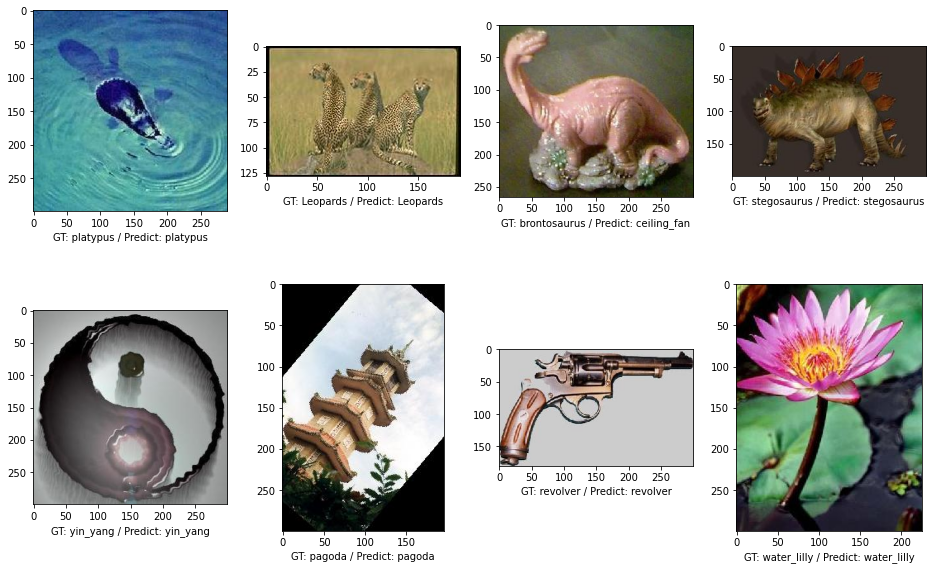

In [109]:
# Show 8 random images
plt.figure(figsize=(16,10))
for i, r_c in enumerate(random.sample(range(len(classes)), 8)):
    # Random sample image from given class
    r_i = random.sample(range(numTest), 1)
    fpath = train_image_ll[r_c][r_i[0]]
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    
    # Get predicted label
    test_res = int(test_preds[r_c * numTest + r_i[0]][0])
    
    plt.subplot(2, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel("GT: {} / Predict: {}".format(classes[r_c], classes[test_res]))

# Practice: Classify your own image

Choose and classify your own test image using our classification.

- Place your image in the path where this notebook can access
- Load an image as grayscale
- Extract Dense SIFT BoW with `getImageDescriptor()`
- Normalize the bow with Hellinger's kernel
- Predict using the SVM classifier we have trained so far(`svm` instance)

In [110]:
!wget https://raw.githubusercontent.com/bckim92/iab_practice_example/master/images/dragonfly.jpg

--2021-09-22 07:40:01--  https://raw.githubusercontent.com/bckim92/iab_practice_example/master/images/dragonfly.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23885 (23K) [image/jpeg]
Saving to: ‘dragonfly.jpg’

dragonfly.jpg       100%[===================>]  23.33K  --.-KB/s    in 0.001s  

2021-09-22 07:40:01 (20.5 MB/s) - ‘dragonfly.jpg’ saved [23885/23885]



In [ ]:
img_fpath = './dragonfly.jpg'  # Path to your own image
img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)

#================ YOUR CODE HERE ===================
getImageDescriptor(img)

prediction = 0  # Predicted class of your image
#===================================================

plt.imshow(cv2.cvtColor(cv2.imread(img_fpath), cv2.COLOR_BGR2RGB))
plt.xlabel("Prediction: {}".format(classes[prediction]))

In [ ]:
# Desired output